# Feature engineering

## Introduction
We always look at a round from the point of view of **team_1**.

## Features: 
- **target**: team_1 won the round
- **kills**: Amount of players killed by team_1
- **deaths**: Amount of players that died from team_1
- **equipment_value_ratio**: Total equipment value compared to equipment value of team_2. *This is better than saving the equipment values from both the teams. $650 in a pistol round is normal. $650 in round 10 can probably be considered as a saving round.*
- **first_kill**: Did team_1 make the first kill. Making the first kill results in a higher chance of winning the round.
- **map**: maybe there are more clutches on Mirage?
- **damage_done**: Amount of damage team1 did to team2
- **damage_taken**: Amount of damage team2 did to team1
- **median_player_health**: Median health of all players of the team.
- **is_bomb_planted**: Is the bomb planted. We can view this in the bombchangesevents.
- **alive_ratio_on_bomb_planted**: Amount of players alive from team_1 compared to players alive from team_2 when the bomb is planted.

# Features to implement
- **distance_from_bomb_on_plant**: Average distance from team_1 when bomb is planted. (Maybe they are already saving)
- **defuse_kit_count**: Amount of defusekits. (
- **utility**: [TODO]


In [86]:
import numpy as np
import pandas as pd

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [73]:
# Feature engineering
from dp.database.mongo import get_collections
import parser
from bson.objectid import ObjectId
from sklearn.model_selection import train_test_split

collections = get_collections()
Round = parser.Round.dataclass()

parsed_rounds = []
target = []
matches = collections["matches"].find({})

# MATCH
for match_idx, match in enumerate(matches):
  round_winstreak = 0
  team_1_id = match["teams"][0]

  # ROUND
  for round_idx, round_id in enumerate(match["rounds"]):
    # Sometimes a round is not parsed correctly and the data is not available.
    round = collections["rounds"].find_one({ "_id": ObjectId(round_id)})
    if round is None:
      continue

    # Create a set of 4 ticks: @35%,@50%,@75%,@100%. To learn the model it does not always has the information of the entire round.
    duration = round["endTick"] - round["startTick"]
    ticks = list(map(lambda n: round["startTick"] + duration*n,[.35,.5,.75,1]))

    # We should only change this once every round. Not for the multiple tick points we check.
    round = parser.Round(round_id,team_1_id,round["endTick"],round_idx, match["map"])

    if round.is_win():
      round_winstreak+= 1
    else:
      round_winstreak=0

    for tick in ticks:
      round = parser.Round(round_id,team_1_id, tick, round_idx, match["map"])
      (kills, deaths) = round.kills_and_deaths()
      target.append(1) if round.is_win() else target.append(0)

      (ct_winrate,t_winrate) = round.map_winrate()
      (damage_given, damage_taken) = round.damage()

      # bomb plant must be checked before players (cause we depend on the bomb plant tick, which is exposed after is_bomb_planted)
      is_bomb_planted = round.is_bomb_planted()
      (team_alive_on_plant, enemy_alive_on_plant) = round.players_alive_on_plant()

      parsed_rounds.append(
        Round(
          kills=kills,
          deaths=deaths,
          first_blood=round.is_first_blood(),
          round_winstreak=round_winstreak,
          bomb_planted=is_bomb_planted,
          is_terrorist=round.is_terrorist(),
          counter_terrorist_map_winrate= ct_winrate,
          terrorist_map_winrate= t_winrate,
          damage_given = damage_given,
          damage_taken= damage_taken,
          team_alive_on_plant=team_alive_on_plant,
          enemy_alive_on_plant=enemy_alive_on_plant,
          )
      )

print("Parsed rounds:", len(parsed_rounds))
data = pd.DataFrame(parsed_rounds)


Parsed rounds: 14796


In [91]:
# Keep this separate otherwise the we can't rerun the cell above.
processed_data = parser.preprocessing(data)
print(processed_data.columns)

Index(['kills', 'deaths', 'round_winstreak', 'bomb_planted', 'is_terrorist',
       'counter_terrorist_map_winrate', 'terrorist_map_winrate',
       'damage_given', 'damage_taken', 'team_alive_on_plant',
       'enemy_alive_on_plant', 'first_blood__0.0', 'first_blood__1.0',
       'first_blood__nan'],
      dtype='object')


In [87]:
# We should how diverse our dataset is. If in 80% of our games team_1 wins.
# We will learn the model that it can always pick team_1 and get an accuracy of 80%. We don't want that :)

# Split the data in training and testing data
train_X,test_X, train_Y, test_Y = train_test_split(processed_data,target,test_size=0.3, random_state=42)
print(train_X)


       kills  deaths  round_winstreak  bomb_planted  is_terrorist  \
1584       2       0                0             0             0   
10678      2       1                1             0             1   
12628      0       0                2             0             1   
9570       4       1                1             1             0   
1975       0       5                2             0             1   
...      ...     ...              ...           ...           ...   
5191       5       1                1             0             0   
13418      4       2                0             0             0   
5390       3       2                0             1             1   
860        0       0                0             1             0   
7270       3       2                3             0             1   

        counter_terrorist_map_winrate           terrorist_map_winrate  \
1584   0.4897959183673469387755102041  0.5102040816326530612244897959   
10678  0.5693069306930693

# Hyperparameter tuning
With SVM we try to find the maximum margin separator between our two classes (team_1_wins, team_2_wins). This is the line the furtest from the nearest training data points. SVM calculates the distance to the closest datapoint for each possible line and picks the one with the highest distance. This makes an SVM a **maximum margin estimator. 

In most real probelms, it is not possible to find the perfect separating plane. Sometimes there are datapoints that are not closer to the other class. To handle this we allow the SVM to soften the margin. Which means we allow some of the points to creep into the margin if that allows a better fit. This transforms our SVM into a soft-margin classifier since we are allowing for a few mistakes. This is typically called C.

C is a hyperparameter that needs to be tuned based on the dataset.

In [88]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {
  "kernel": ["linear","rbf", "sigmoid"],
  "C": range(1,20),
}

# Not completely sure what this degree is doing.
clf = GridSearchCV(svm.SVC(probability=True, random_state=42, degree=3), parameters)
clf.fit(train_X, train_Y)


GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid={'C': range(1, 20),
                         'kernel': ['linear', 'rbf', 'sigmoid']})

accuracy:100.0%
f1 score:1.0%
report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1401
           1       1.00      1.00      1.00      1559

    accuracy                           1.00      2960
   macro avg       1.00      1.00      1.00      2960
weighted avg       1.00      1.00      1.00      2960



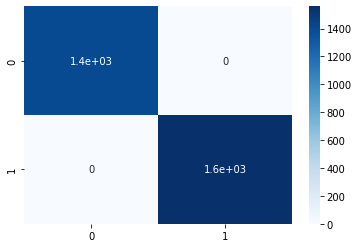

In [82]:
# This is still crappp
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import seaborn

# Performance metrics
predictions = clf.predict(test_X)

accuracy = accuracy_score(test_Y, predictions, normalize=True)
print(f"accuracy:{accuracy*100}%")

f1_score = f1_score(test_Y, predictions)
print(f"f1 score:{f1_score}%")

report = classification_report(test_Y, predictions)
print(f"report: {report}")

cf_matrix = confusion_matrix(test_Y, predictions)
seaborn.heatmap(cf_matrix, annot=True, cmap="Blues")

probabilities = clf.predict_proba(test_X)


In [90]:
import pickle

# Dump model to disk
try:
  filename = "../model/model.sav"
  pickle.dump(clf, open(filename, 'wb'))
except pickle.PickleError:
  print("Could not dump model.")




# Live demo parsing

A second part, we unfortunately had no time to implement, is **live demo parsing**.

We need to start by creating a probability N by N matrix, with N the different states.
This is also called a ** stochastic matrix**. Each combination of a row(x) and a column(y) is the probability to go from stateX to stateY.

Since we eventually want to find the winner of a game we also need something called absorbing states. **An absorbing state is a state that, once entered, cannot be left**: In this case ["team1_wins", "team2_wins"]
